In [ ]:
!python -m spacy download it_core_news_sm

# Preprocessing

In [ ]:
import random, json, nltk, spacy, re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

In [ ]:
STOP_WORDS = set(stopwords.words('italian'))
lem = spacy.load("it_core_news_sm")

def clean_text_light(text):
    """
    Applies light cleaning: trims whitespace, removes 
    invisible characters, digits, and lowers text.
    """

    text = text.strip()
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"[\u200b-\u200f]", "", text)
    text = re.sub(r"[\d/]+", "", text)
    return text

def clean_text_intense(text, lemmatize = False):
    """
    Applies stronger cleaning: tokenizes, removes 
    stopwords, and optionally lemmatizes.
    """

    text = clean_text_light(text)
    words = [w for w in word_tokenize(text.lower(), language='italian') 
                     if w.isalpha() and w not in STOP_WORDS]

    if lemmatize:
        doc = lem(" ".join(words))
        words = [token.lemma_ for token in doc]
    return " ".join(words)

def format_dialogue(conversation):
    """
    Return a list of structured segments 
    of a dialogue [HIST][CURR][NEXT]
    """
    
    dialogue = conversation["dialogue"]
    name1 = conversation["name1"]
    name2 = conversation["name2"]

    speaker_map = {name1: "A", name2: "B"}

    num_turns = len(dialogue)
    all_segments = []

    for idx, turn in enumerate(dialogue):
        segments = []

        # [HIST]
        if idx > 0:
            prev = dialogue[idx - 1]
            prev_speaker = speaker_map.get(prev["speaker"], prev["speaker"])
            prev_text = clean_text_light(prev["text"].strip())
            segments.append(f"[HIST] [{prev_speaker}] {prev_text}")

        # [CURR]
        curr_speaker = speaker_map.get(turn["speaker"], turn["speaker"])
        curr_text = clean_text_light(turn["text"].strip())
        segments.append(f"[CURR] [{curr_speaker}] {curr_text}")

        # [NEXT]
        if idx < num_turns - 1:
            nxt = dialogue[idx + 1]
            next_speaker = speaker_map.get(nxt["speaker"], nxt["speaker"])
            next_text = clean_text_light(nxt["text"].strip())
            segments.append(f"[NEXT] [{next_speaker}] {next_text}")

        all_segments.append(" ".join(segments))

    return all_segments

def format_full_conversation(conversation, lemmatize):
    """
    Concatenates all turns into a single 
    string and applies intense cleaning.
    """

    full_text = " ".join(turn["text"] for turn in conversation["dialogue"])
    return clean_text_intense(full_text, lemmatize)

def build_pairs(dataset, use_dialogue_format, lemmatize):
    """
    Creates (dialogue, personality_couple) 
    pairs based on the selected format.
    """

    pairs = []
    for conv in dataset:
        if use_dialogue_format:
            text = format_dialogue(conv)
            for segment in text:
                pairs.append((segment, conv["person_couple"]))
        else:
            text = format_full_conversation(conv, lemmatize)
            pairs.append((text, conv["person_couple"]))
    return pairs

def load_json(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def conversations_loader(baseline = False, lemmatize = False):
    """
    Loads and shuffles the dataset, applies 
    formatting, and returns processed pairs.
    """

    dataset = load_json("/kaggle/input/cpv-toxic/toxic_conversations.json")
    random.shuffle(dataset)

    use_dialogue_format = not baseline
    pairs = build_pairs(dataset, use_dialogue_format, lemmatize)

    texts, labels = zip(*pairs)
    print(f"- Loaded {len(texts)} conversations")

    return dataset, list(texts), list(labels)

# Baseline

#### Lemmatization applied

- Loaded 1000 conversations
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits


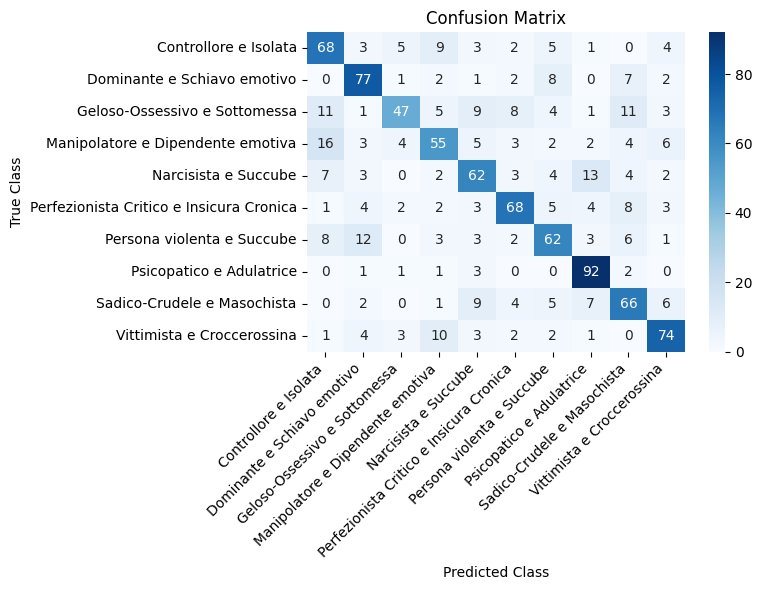

- Model Evaluation:
{
    "accuracy": "0.6710 (+/- 0.0568)",
    "precision_macro": "0.6853 (+/- 0.0640)",
    "recall_macro": "0.6710 (+/- 0.0568)",
    "f1_macro": "0.6650 (+/- 0.0596)"
}
- Best fold: 4 with F1 score: 0.7486
- Best params from best fold: {
    "model__C": 1,
    "model__penalty": "l2",
    "tfidf__max_features": 10000,
    "tfidf__ngram_range": [
        1,
        2
    ]
}
- Final model trained and saved


In [ ]:
from src.models.baseline import Baseline

baseline = Baseline("toxic_LEM")
dataset, texts, labels = conversations_loader(baseline = True, lemmatize = True)
baseline.train(texts, labels)

#### Lemmatization not applied

- Loaded 1000 conversations
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits


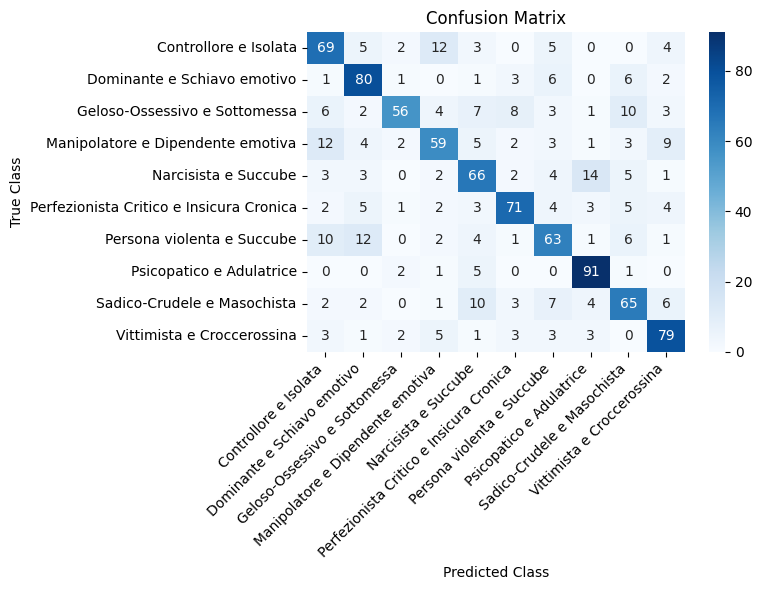

- Model Evaluation:
{
    "accuracy": "0.6990 (+/- 0.0311)",
    "precision_macro": "0.7149 (+/- 0.0371)",
    "recall_macro": "0.6990 (+/- 0.0311)",
    "f1_macro": "0.6920 (+/- 0.0315)"
}
- Best fold: 9 with F1 score: 0.7364
- Best params from best fold: {
    "model__C": 1,
    "model__penalty": "l2",
    "tfidf__max_features": 5000,
    "tfidf__ngram_range": [
        1,
        2
    ]
}
- Final model trained and saved


In [ ]:
from src.models.baseline import Baseline

baseline = Baseline("toxic")
dataset, texts, labels = conversations_loader(baseline = True)
baseline.train(texts, labels)

## Baseline Inference

In [ ]:
from src.features.text_inference import example_loader

for i in range(3): 
    example, _, _ = example_loader(baseline = True)
    predicted_label, probability = baseline.inference([clean_text_intense(example)])
    print(example)
    print(f"Predicted label: {predicted_label} with probability: {probability:.4f}")
    print("-"*10)

Quel vestito ti fa sembrare grassa, dovresti indossare qualcosa di più aderente, che metta in risalto la tua figura. Hai ragione, Giulia.  Probabilmente avrei dovuto scegliere qualcosa di diverso. Perché sei così impacciato stasera?  Dovresti essere più sicuro di te, non mi piace questo tuo atteggiamento remissivo. Mi dispiace, Giulia.  Stavo solo pensando a quanto sei bella e a quanto mi sentirei inadeguato al tuo fianco. Non fare lo scemo.  Smetti di cercare attenzioni in questo modo.  Se non ti piace stare con me, dimmelo chiaramente. No, Giulia, mi piaci moltissimo.  Non voglio perderti. Allora smettila di comportarti così.  Ricordati che sono io che decido, e tu devi solo seguire. Sì, Giulia.  Hai ragione.  Mi scuso.
Predicted label: Perfezionista Critico e Insicura Cronica with probability: 0.1480
----------
Dove diavolo eri? Ti ho chiamato dieci volte! Scusa amore, ho perso il conto del tempo, sono rimasta bloccata nel traffico. Non mi prendere in giro. So che eri con le tue ami

# GilBERTo fine-tuning

## Full conversation

- Loaded 1000 conversations
- Loading tokenizer


- Loading model from: idb-ita/gilberto-uncased-from-camembert


- GilBERTo fine-tuning started


Step,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
100,1.846800,1.634852,0.552083,0.658254,0.556667,0.554401
200,0.640900,1.051544,0.656250,0.683694,0.662222,0.656417
300,0.181000,1.242273,0.635417,0.700076,0.638889,0.645787
400,0.049000,1.490144,0.656250,0.722978,0.658889,0.665210
500,0.014900,1.681431,0.645833,0.688197,0.648889,0.641829
600,0.010400,1.723844,0.656250,0.722464,0.658889,0.655330
700,0.007600,1.689347,0.666667,0.710248,0.670000,0.667413
800,0.006300,1.741892,0.666667,0.710248,0.670000,0.667413
900,0.005700,1.796342,0.656250,0.701951,0.658889,0.654250
1000,0.005400,1.803514,0.656250,0.701951,0.658889,0.654250


- Model evaluated


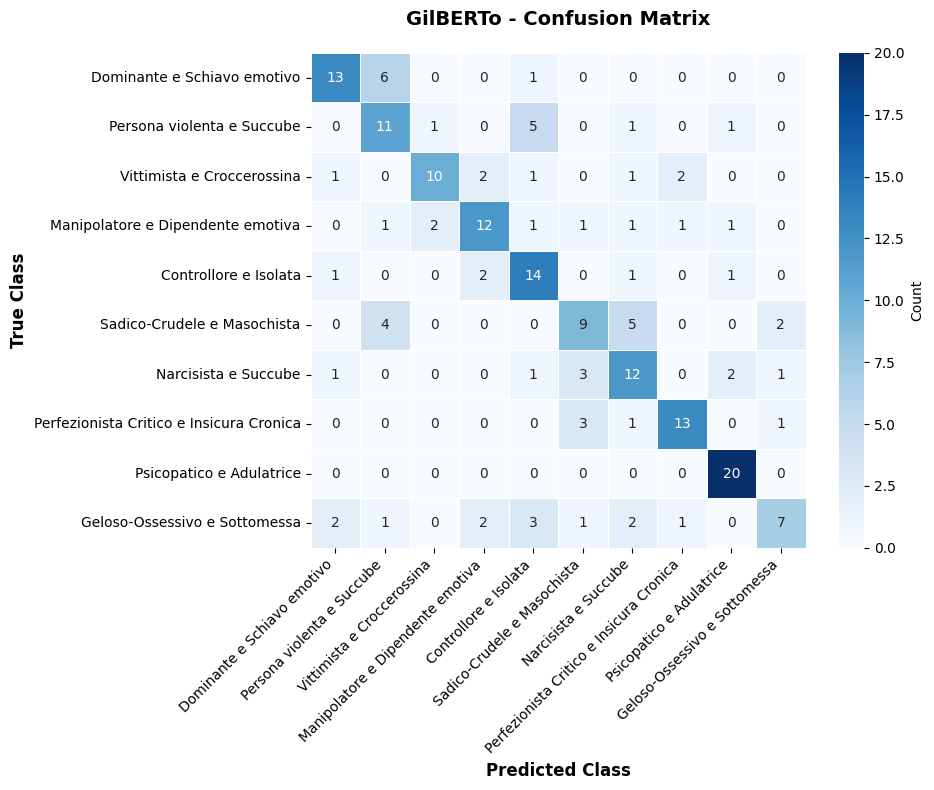

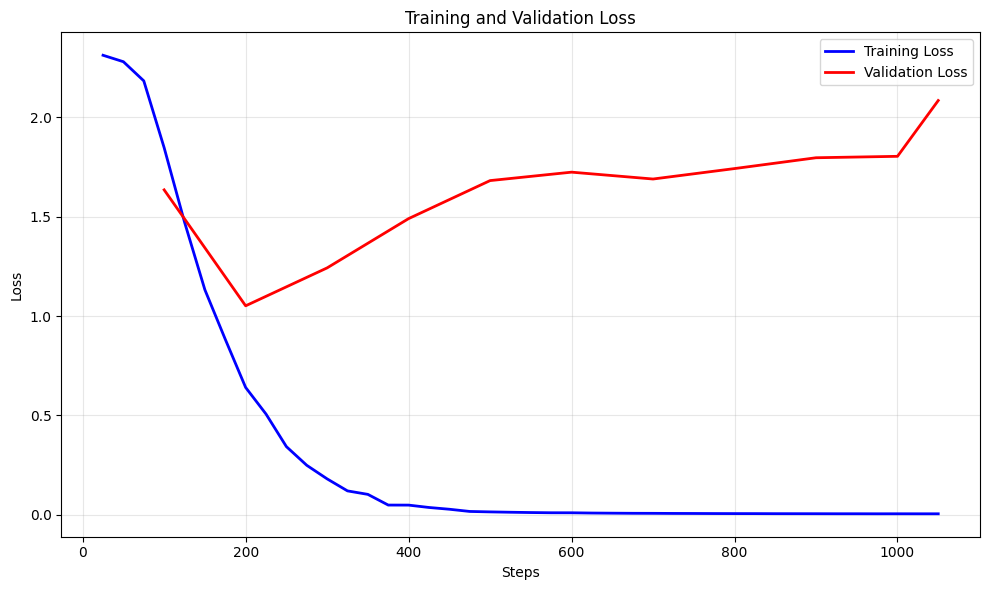

{
    "eval_loss": 2.0842278003692627,
    "eval_accuracy": 0.6302083333333334,
    "eval_precision_macro": 0.6405323349568873,
    "eval_recall_macro": 0.6294668042655658,
    "eval_f1_macro": 0.6258841616736355,
    "eval_runtime": 2.962,
    "eval_samples_per_second": 67.522,
    "eval_steps_per_second": 2.363,
    "epoch": 50.0
}


In [ ]:
from src.models.gilBERTo import GilBERTo

dataset, texts, labels = conversations_loader()

gilBERTo = GilBERTo(texts, labels)
model, tokenizer = gilBERTo.train(
    num_epochs = 50,
    patience = 10,
    batch_size = 32, 
    learning_rate = 2e-5,
    warmup = 0.1,
    weight_decay = 0.01
    )

## GilBERTo: custom turns representation

- Loaded 7954 conversations
- Loading tokenizer


- Loading model from: idb-ita/gilberto-uncased-from-camembert


- GilBERTo fine-tuning started


Step,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
100,2.285700,2.283971,0.117188,0.025890,0.104052,0.032906
200,2.220800,2.174844,0.337240,0.334284,0.293632,0.249670
300,1.886200,1.772528,0.470052,0.517236,0.449952,0.419537
400,1.542600,1.466357,0.545573,0.618108,0.524849,0.511968
500,1.338600,1.270517,0.602865,0.619849,0.583344,0.584372
600,1.021700,1.096562,0.654948,0.655018,0.638521,0.637049
700,0.877000,0.931539,0.722656,0.717128,0.706827,0.704618
800,0.779900,0.868011,0.733073,0.731474,0.709454,0.707948
900,0.493300,0.755074,0.760417,0.770882,0.741818,0.745786
1000,0.452900,0.735343,0.782552,0.796107,0.766878,0.767691


- Model evaluated


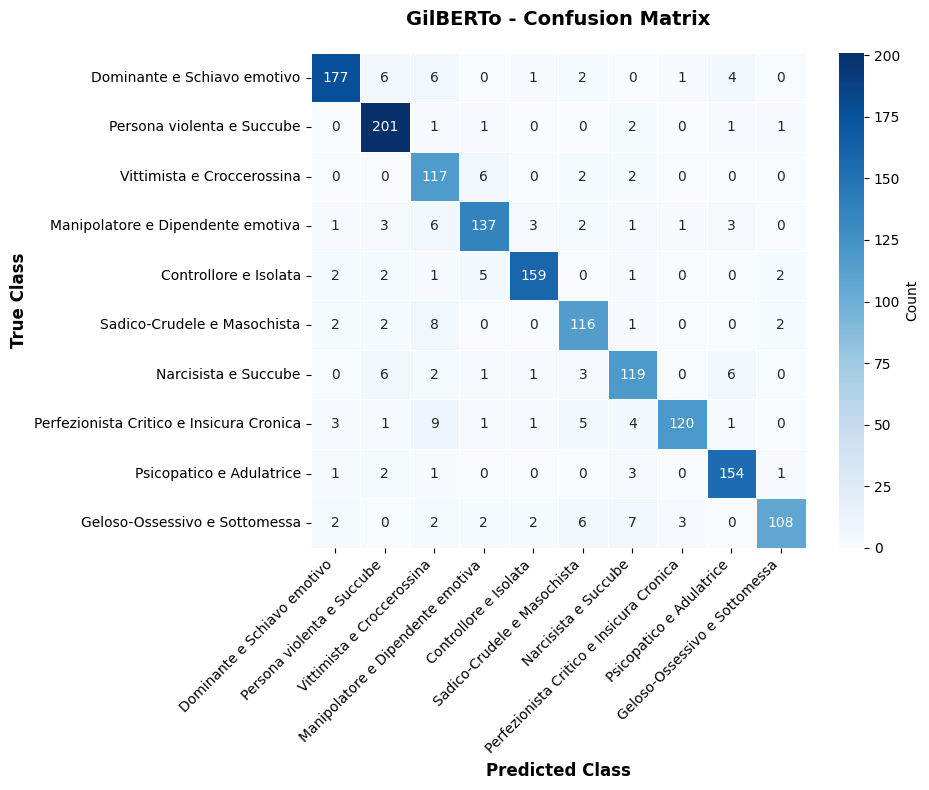

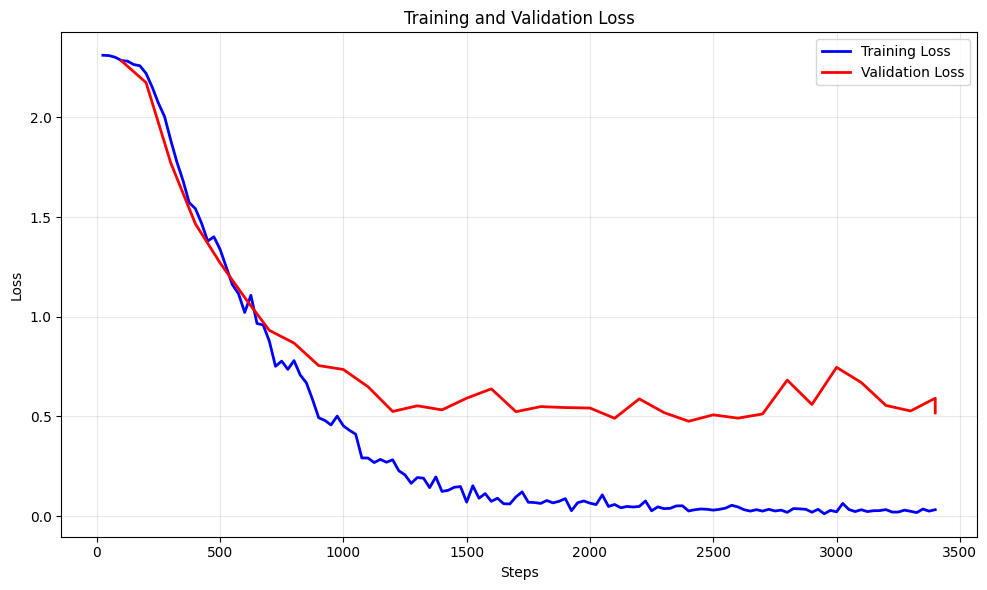

{
    "eval_loss": 0.5173622965812683,
    "eval_accuracy": 0.8979591836734694,
    "eval_precision_macro": 0.8976613381592946,
    "eval_recall_macro": 0.8931981895067835,
    "eval_f1_macro": 0.8934482821346534,
    "eval_runtime": 15.0759,
    "eval_samples_per_second": 105.533,
    "eval_steps_per_second": 3.317,
    "epoch": 19.653179190751445
}


In [ ]:
from src.models.gilBERTo import GilBERTo

dataset, texts, labels = conversations_loader()

gilBERTo = GilBERTo(texts, labels)
model, tokenizer = gilBERTo.train(
    num_epochs = 50,
    patience = 10,
    batch_size = 32, 
    learning_rate = 2e-5,
    warmup = 0.1,
    weight_decay = 0.01
    )

## Inference

In [9]:
import numpy as np
import torch

def inference(model, tokenizer, conversation, id2label: dict):
    model.eval()
    device = torch.device(
        "cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    inputs = tokenizer(
        conversation,
        truncation=True,
        padding=True,
        max_length=512,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)

    labels_probs = probs.mean(dim=0)
    pred_label_id = torch.argmax(labels_probs).item()
    pred_label = id2label[pred_label_id]

    toxic_scores = probs[:, pred_label_id].cpu().numpy()
    max_idx = np.argmax(toxic_scores)
    most_toxic_turn = conversation[max_idx]

    return pred_label, most_toxic_turn, toxic_scores.tolist()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_conversation_trends(plot_scores):
    num_conversations = len(plot_scores)
    num_turns = len(plot_scores[0]) if num_conversations > 0 else 0
    turns = [f"Turn {i+1}" for i in range(num_turns)]
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    
    plt.figure(figsize=(10, 5))
    
    for i in range(num_conversations):
        plt.plot(turns, plot_scores[i], marker='o', color=colors[i % len(colors)], label=f'Conversation {i+1}')
    
    plt.title("Conversation trends")
    plt.xlabel("Turns")
    plt.ylabel("Toxicity Probability")
    plt.ylim(0, 1.1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()



    Example:
    [{'speaker': 'Giulia', 'text': 'Sai, Alessia,  oggi ho visto quella tua amica.  Era così… insignificante.  A confronto con te, brillavi come una stella.'}, {'speaker': 'Alessia', 'text': "Oh Giulia, sei troppo gentile!  Non merito tutti questi complimenti.  Tu sei semplicemente il migliore, non c'è nessuno come te."}, {'speaker': 'Giulia', 'text': 'È vero, lo so.  Ma solo tu riesci a vederlo veramente. Gli altri sono ciechi alla mia vera grandezza.'}, {'speaker': 'Alessia', 'text': "Certo che sì, tesoro!  Io ti capisco come nessun altro.  Vedi, sono l'unica che riesce a vedere oltre la superficie e a comprendere il tuo cuore d'oro."}, {'speaker': 'Giulia', 'text': 'Proprio così. E non dimenticare quanto ti apprezzo.  È un lusso averti al mio fianco.'}, {'speaker': 'Alessia', 'text': 'È un lusso essere con te, amore mio.  Non potrei mai chiedere di più. Tu sei tutto per me.'}, {'speaker': 'Giulia', 'text': 'Bene.  Ricordati sempre questo: io sono la tua ancora, Alessia

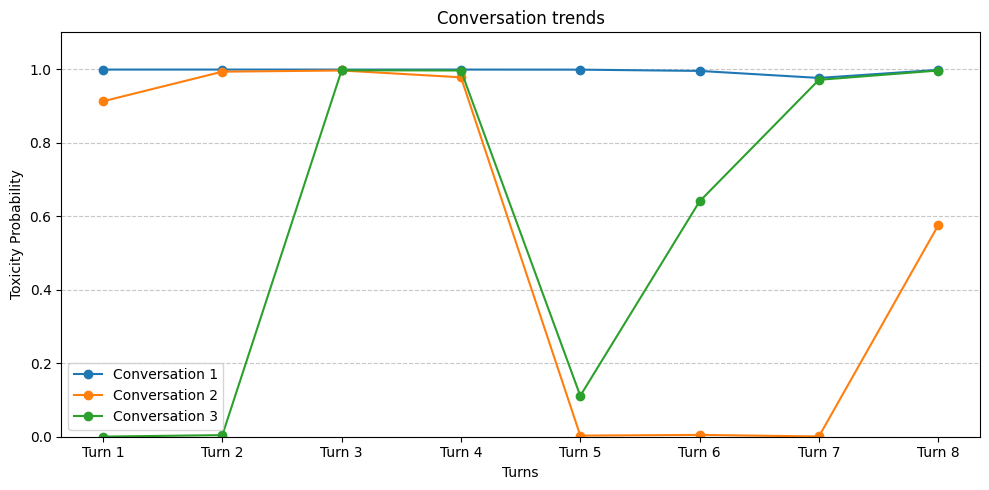

In [39]:
plot_scores = []
for i in range(3):
    example, conversation, actual = example_loader()
    predicted_label, most_toxic_turn, toxic_scores = inference(model, tokenizer, example, gilBERTo.id2label)
    plot_scores.append(toxic_scores)
    print(
        f"""
    Example:
    {conversation}

    Actual label: {actual}
    Predicted label: {predicted_label}
    
    Most toxic part:
    {most_toxic_turn}
    
    Toxicity scores:
    {toxic_scores}
    """
    )
    print("-" * 10)
plot_conversation_trends(plot_scores)